In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout, SpatialDropout1D, Input, Layer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [13]:

# Load IMDB dataset (Keras version for convenience)
from tensorflow.keras.datasets import imdb

# Hyperparameters
max_words = 5000  # Max number of words in the vocabulary
max_len = 200     # Max sequence length
embedding_dim = 100  # Embedding dimensions (random initialization)

# Load the IMDB dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train, maxlen=max_len)
X_test_pad = pad_sequences(X_test, maxlen=max_len)

In [18]:
# Attention Layer (compatible with Keras)
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [19]:
# Model Architecture with Bidirectional GRU + Attention
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim)(input_layer)  # Embedding learned during training
spatial_dropout = SpatialDropout1D(0.2)(embedding_layer)
gru_layer = Bidirectional(GRU(units=128, return_sequences=True))(spatial_dropout)
attention_output = Attention()(gru_layer)
dense_layer = Dense(64, activation='relu')(attention_output)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

In [20]:
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.5615 - loss: 0.6710 - val_accuracy: 0.8406 - val_loss: 0.3651
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.8576 - loss: 0.3489 - val_accuracy: 0.8684 - val_loss: 0.3126
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.8892 - loss: 0.2837 - val_accuracy: 0.8629 - val_loss: 0.3173
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - accuracy: 0.9086 - loss: 0.2458 - val_accuracy: 0.8737 - val_loss: 0.3064
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 557s 1s/step - accuracy: 0.9161 - loss: 0.2277 - val_accuracy: 0.8720 - val_loss: 0.3067
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.9205 - loss: 0.2151 - val_accuracy: 0.8710 - val_loss: 0.3438
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0.9191 - loss: 0.2166 - val_accuracy: 0.8683 - val_loss: 0.3376
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 540s 1s/step - accuracy: 0.9286 - loss: 0.1960 - val_accu

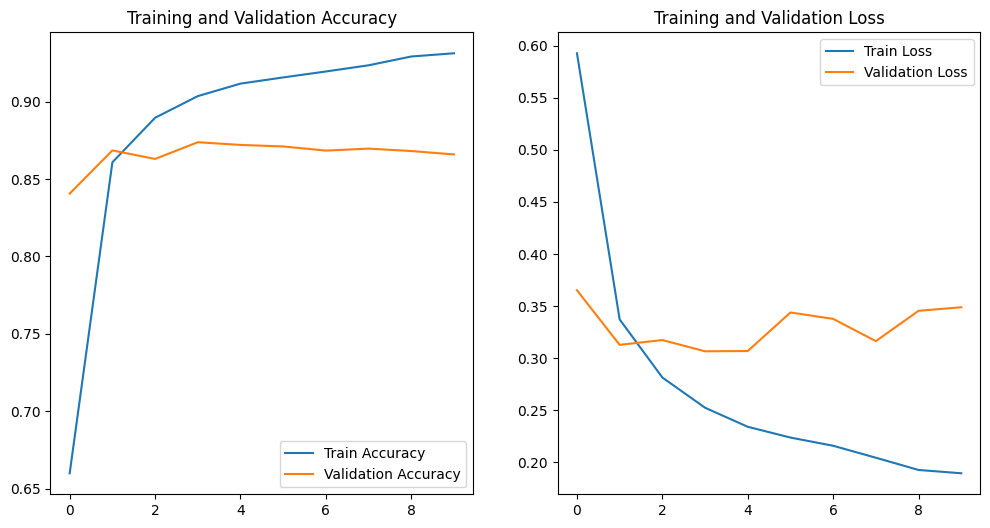

In [21]:
# Plotting accuracy and loss over time
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Call the plot function to visualize results
plot_history(history)

In [31]:
# Example reviews for prediction
example_reviews = [
    "The movie was fantastic! I really enjoyed the performances and the story was very engaging.",
    "This movie is too good."
]

# Tokenize and preprocess example reviews
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(example_reviews)
example_sequences = tokenizer.texts_to_sequences(example_reviews)
example_padded = pad_sequences(example_sequences, maxlen=max_len)

# Predict sentiment using the trained model
predictions = model.predict(example_padded)

# Output predictions with sentiment label
for i, review in enumerate(example_reviews):
    print(f"Review: {review}")
    sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
    print(f"Predicted Sentiment: {sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Review: The movie was fantastic! I really enjoyed the performances and the story was very engaging.
Predicted Sentiment: Positive

Review: This movie is too good.
Predicted Sentiment: Positive

